## Packages

In [18]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Loading the data

In [19]:
raw_data = yfinance.download (tickers = "SBIN.NS,YESBANK.NS,INDUSINDBK.NS,PNB.NS", start = "2010-04-01", 
                              end = "2020-04-22", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [20]:
df_comp = raw_data.copy()

In [21]:
#main stock
df_comp['INDUSINDBK'] = df_comp['INDUSINDBK.NS'].Close[:]
#influencing Stock
df_comp['SBIN'] = df_comp['SBIN.NS'].Close[:]
df_comp['YESBANK'] = df_comp['YESBANK.NS'].Close[:]
df_comp['PNB'] = df_comp['PNB.NS'].Close[:]



In [22]:
df_comp = df_comp.iloc[1:]
del df_comp['PNB.NS']
del df_comp['YESBANK.NS']
del df_comp['INDUSINDBK.NS']
del df_comp['SBIN.NS']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [23]:
df_comp.head()

,INDUSINDBK,SBIN,YESBANK,PNB
,,,,
Date,,,,
2010-04-05,169.286942,93.521843,33.912960,99.848930
2010-04-06,168.865585,92.878891,33.681908,100.758369
2010-04-07,168.537903,92.325615,33.431610,98.988113
2010-04-08,167.133423,91.669548,33.367424,97.952232
2010-04-09,167.414337,92.115677,33.842358,97.884155


In [24]:
df_comp.tail()

,INDUSINDBK,SBIN,YESBANK,PNB
,,,,
Date,,,,
2020-04-15,424.100006,182.350006,24.500000,31.100000
2020-04-16,435.399994,188.500000,24.600000,31.049999
2020-04-17,474.450012,193.250000,25.100000,31.799999
2020-04-20,456.700012,192.500000,29.450001,32.849998
2020-04-21,400.850006,184.750000,29.650000,31.100000


## Creating Returns

In [25]:

df_comp['ret_SBIN'] = df_comp.SBIN.pct_change(1).mul(100)
df_comp['ret_INDUSINDBK'] = df_comp.INDUSINDBK.pct_change(1).mul(100)
df_comp['ret_YESBANK'] = df_comp.YESBANK.pct_change(1).mul(100)
df_comp['ret_PNB'] = df_comp.PNB.pct_change(1).mul(100)


In [26]:
df_comp['norm_ret_SBIN'] = df_comp.ret_SBIN.div(df_comp.ret_SBIN[1])*100
df_comp['norm_ret_INDUSINDBK'] = df_comp.ret_INDUSINDBK.div(df_comp.ret_INDUSINDBK[1])*100
df_comp['norm_ret_YESBANK'] = df_comp.ret_YESBANK.div(df_comp.ret_YESBANK[1])*100
df_comp['norm_ret_PNB'] = df_comp.ret_PNB.div(df_comp.ret_PNB[1])*100



## Splitting the Data

In [27]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitting a Model

In [28]:
model_ar = ARIMA(df.INDUSINDBK, order = (1,0,0))
results_ar = model_ar.fit()

## Simple Forecasting

In [29]:
df.tail()

,INDUSINDBK,SBIN,YESBANK,PNB,ret_SBIN,ret_INDUSINDBK,ret_YESBANK,ret_PNB,norm_ret_SBIN,norm_ret_INDUSINDBK,norm_ret_YESBANK,norm_ret_PNB
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2018-04-11,1831.669556,257.049988,301.266846,102.199997,-2.373718,0.422086,-2.270953,-2.851711,345.273865,-169.580260,333.321589,-313.094421
2018-04-12,1833.692993,253.800003,301.025452,101.250000,-1.264340,0.110470,-0.080126,-0.929547,183.907001,-44.383008,11.760626,-102.056608
2018-04-13,1837.147583,250.949997,298.901123,101.300003,-1.122934,0.188395,-0.705697,0.049386,163.338550,-75.690946,103.579473,5.422147
2018-04-16,1840.454102,249.000000,299.673645,99.150002,-0.777046,0.179981,0.258454,-2.122410,113.026757,-72.310437,-37.934862,-233.023172
2018-04-17,1842.625488,248.149994,297.307922,97.949997,-0.341368,0.117981,-0.789433,-1.210292,49.654341,-47.400864,115.869864,-132.880110


In [30]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2018-02-12"
end_date = "2018-03-26"

In [31]:
end_date = "2020-03-26"
df_pred = results_ar.predict(start = start_date, end = end_date)

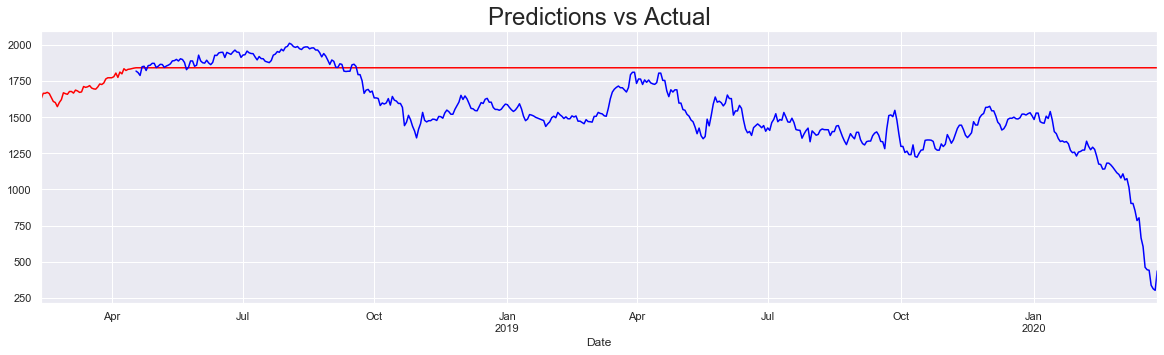

In [32]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Using Returns Instead

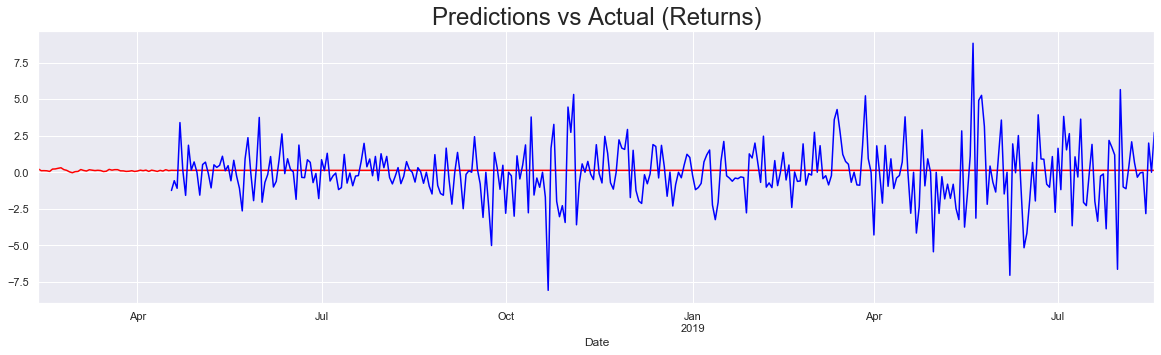

In [33]:
end_date = "2019-08-18"

model_ret_ar = ARIMA(df.ret_INDUSINDBK[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [34]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         ret_INDUSINDBK   No. Observations:                 2096
Model:                     ARMA(5, 0)   Log Likelihood               -4314.476
Method:                       css-mle   S.D. of innovations              1.896
Date:                Thu, 23 Apr 2020   AIC                           8642.951
Time:                        19:32:59   BIC                           8682.486
Sample:                    04-06-2010   HQIC                          8657.433
                         - 04-17-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1320      0.038      3.507      0.000       0.058       0.206
ar.L1.ret_INDUSINDBK    -0.0261      0.022     -1.195      0.232      -0.069       0.017
ar.L2.ret_INDUSINDBK    -0.0197      0.022     -0.905      0.366      -0.063       0.023
ar.L3.ret_INDUSINDBK    -0.0363      0.022     -1.662      0.096      -0.079       0.006
ar.L4.ret_INDUSINDBK    -0.0324      0.022     -1.486      0.137      -0.075       0.010
ar.L5.ret_INDUSINDBK     0.0145      0.022      0.663      0.508      -0.028       0.057
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6637           -1.2643j            2.0896           -0.3966
AR.2           -1.6637           +1.2643j            2.0896            0.3966
AR.3            1.0147           -1.8560j            2.1153           -0.1704
AR.4            1.0147           +1.8560j            2.1153            0.1704
AR.5            3.5409           -0.0000j            3.5409           -0.0000
-----------------------------------------------------------------------------
"""

### MA

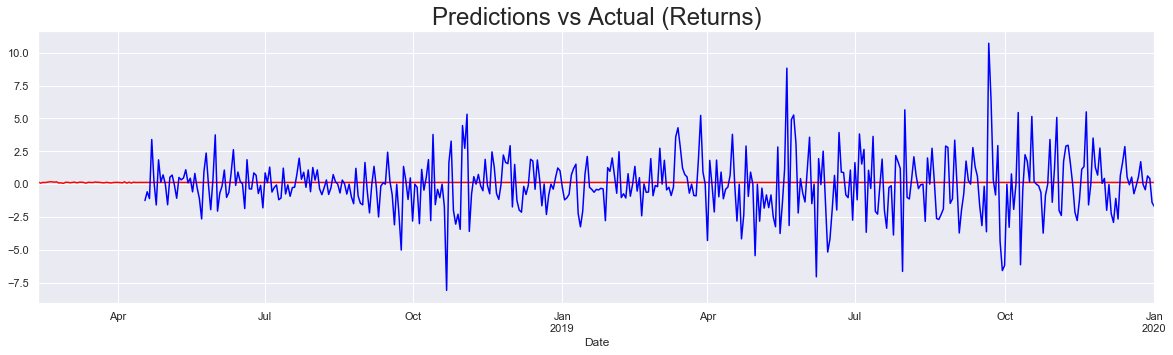

In [35]:
end_date = "2020-01-01"

model_ret_ma = ARIMA(df.ret_INDUSINDBK[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [36]:
df_pred_ma.head()

2018-02-12    0.166835
2018-02-13    0.078043
2018-02-14    0.133943
2018-02-15    0.125397
2018-02-16    0.147522
Freq: B, dtype: float64

### ARMA

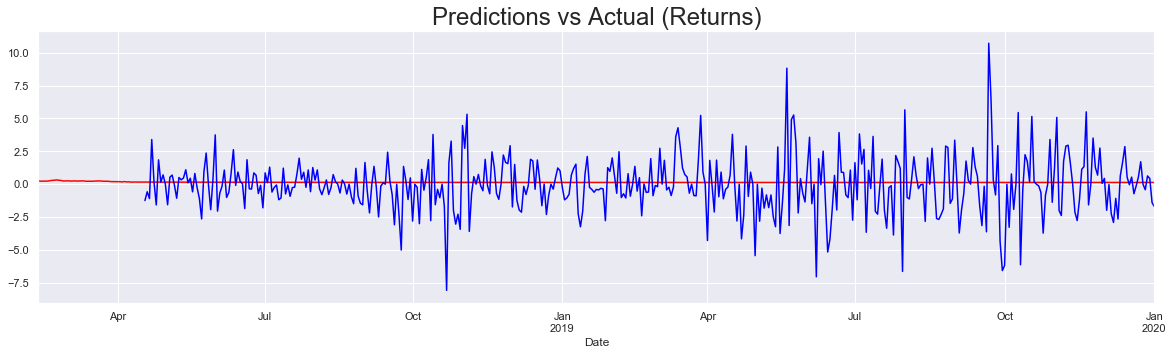

In [37]:
model_ret_arma = ARIMA(df.ret_INDUSINDBK[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [38]:
df_pred_arma.head()

2018-02-12    0.258778
2018-02-13    0.226034
2018-02-14    0.227966
2018-02-15    0.223960
2018-02-16    0.233274
Freq: B, dtype: float64

In [39]:
df_pred_arma.tail()

2019-12-26    0.131118
2019-12-27    0.131118
2019-12-30    0.131117
2019-12-31    0.131117
2020-01-01    0.131116
Freq: B, dtype: float64

### ARMAX

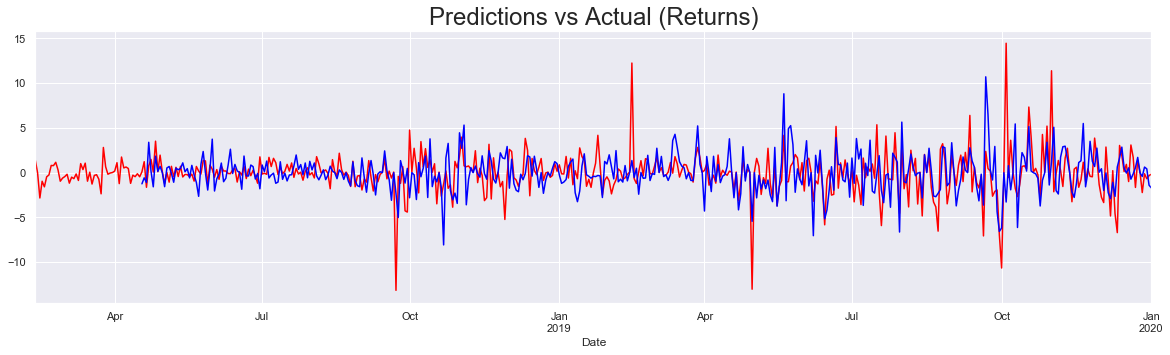

In [40]:
model_ret_armax = ARIMA(df.ret_INDUSINDBK[1:], exog = df[["ret_SBIN","ret_YESBANK","ret_PNB"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_SBIN","ret_YESBANK","ret_PNB"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### SARMA

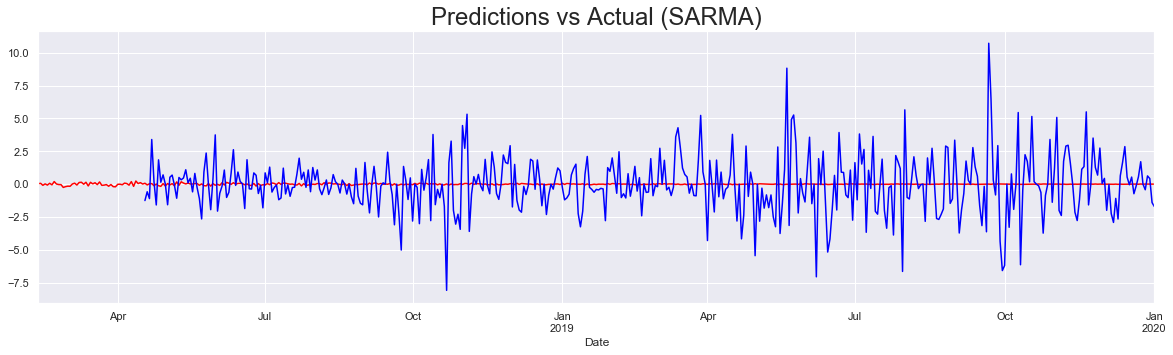

In [41]:
end_date = "2020-01-01"
model_ret_sarma = SARIMAX(df.ret_INDUSINDBK[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

In [42]:
df_test.head()

,INDUSINDBK,SBIN,YESBANK,PNB,ret_SBIN,ret_INDUSINDBK,ret_YESBANK,ret_PNB,norm_ret_SBIN,norm_ret_INDUSINDBK,norm_ret_YESBANK,norm_ret_PNB
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2018-04-18,1819.677124,246.449997,298.901123,97.150002,-0.685068,-1.245417,0.535876,-0.816739,99.647957,500.367080,-78.653711,-89.671178
2018-04-19,1809.165405,246.149994,307.543243,96.099998,-0.121730,-0.577669,2.891297,-1.080806,17.706445,232.088417,-424.373230,-118.663608
2018-04-20,1789.326294,241.199997,297.935547,93.599998,-2.010968,-1.096589,-3.124015,-2.601457,292.509267,440.573132,458.530579,-285.618562
2018-04-23,1850.077637,242.449997,302.280731,94.099998,0.518242,3.395208,1.458431,0.534188,-75.381928,-1364.081775,-214.062749,58.649453
2018-04-24,1853.038696,240.600006,312.854034,93.150002,-0.763040,0.160051,3.497842,-1.009561,110.989508,-64.303004,-513.399498,-110.841500


### SARIMAX

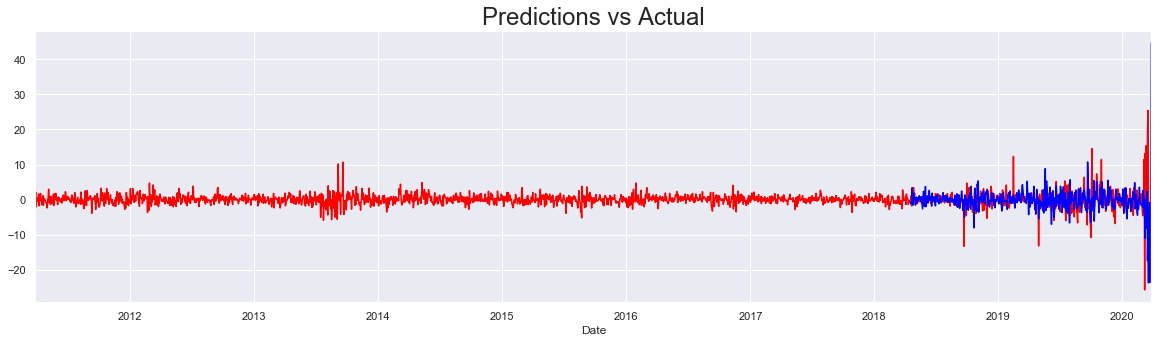

In [43]:
start_date="2011-03-29"
end_date = "2020-03-26"
model_ret_sarimax = SARIMAX(df.ret_INDUSINDBK[1:], exog = df[["ret_SBIN","ret_YESBANK","ret_PNB"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_SBIN","ret_YESBANK","ret_PNB"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()



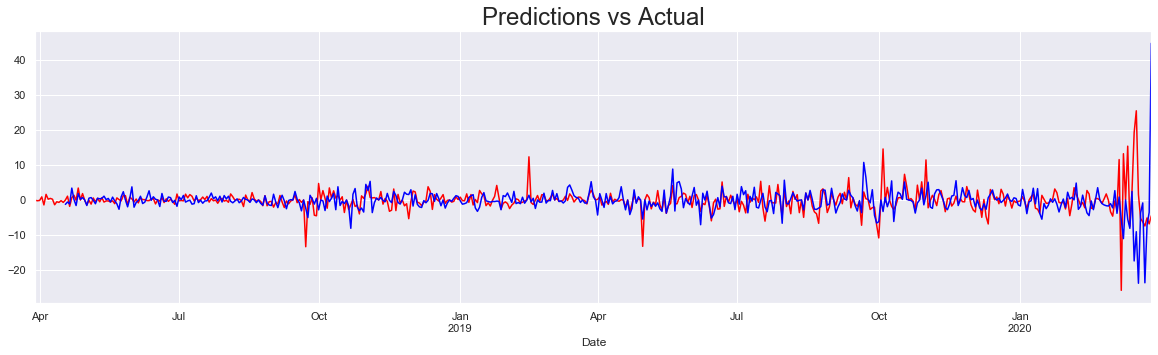

In [44]:
start_date="2018-03-29"

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_SBIN","ret_YESBANK","ret_PNB"]][start_date:end_date]) 


df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Auto ARIMA

In [45]:
model_auto = auto_arima(df.ret_INDUSINDBK[1:], exogenous = df[["ret_SBIN","ret_YESBANK","ret_PNB"]][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [46]:
start_date="2018-03-29"
end_date = "2020-03-26"
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[["ret_SBIN","ret_YESBANK","ret_PNB"]][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

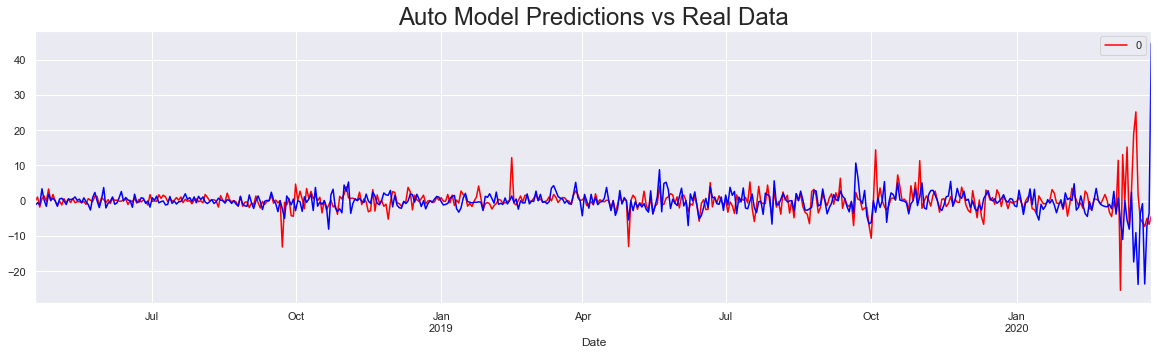

In [47]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

### Comparing All the Models (Returns)

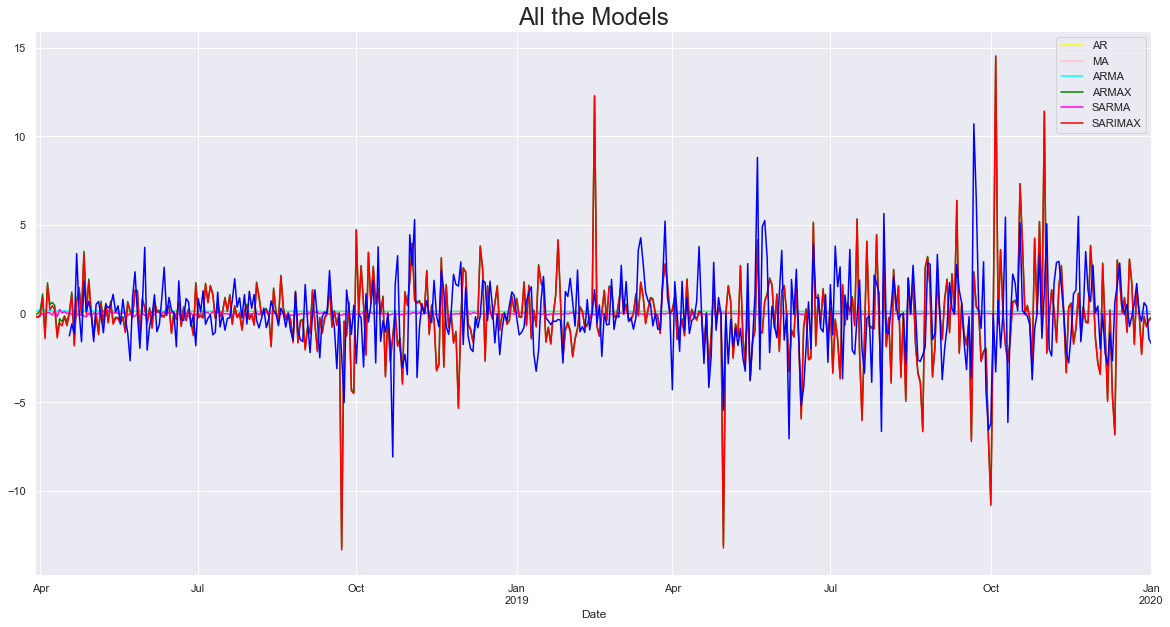

In [48]:
end_date = "2020-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_INDUSINDBK[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

### Forecasting Volatility

In [49]:
mod_garch = arch_model(df_comp.ret_INDUSINDBK[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     73,   Neg. LLF: 4140.413398556159
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4140.412994816887
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


In [50]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

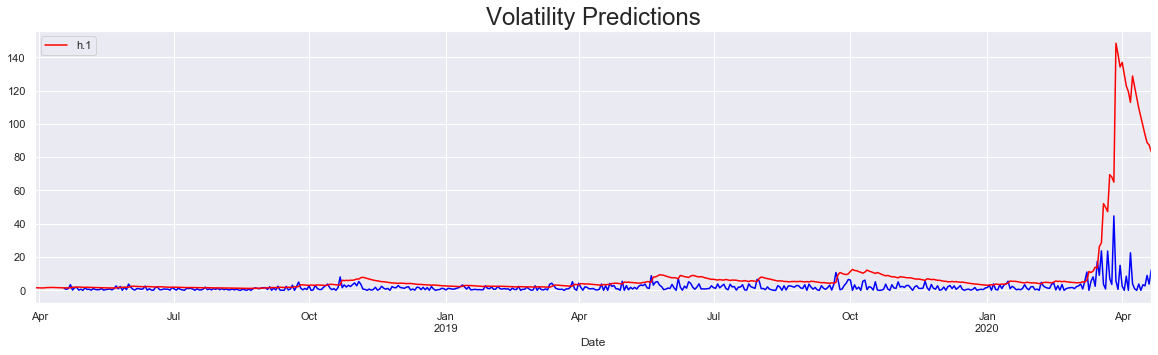

In [51]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_INDUSINDBK.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [52]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-21,83.277949,86.442154,86.928907,90.677763,94.431999,98.805916,102.808996,107.568563,112.496919,117.088782,...,3.912606,3.992164,3.953122,3.998097,4.078341,4.03472,4.093927,4.027901,4.018635,4.100077


### Multvariate Regression Model

In [53]:
from statsmodels.tsa.api import VAR

In [54]:
df_ret = df[["ret_SBIN","ret_YESBANK","ret_PNB","ret_INDUSINDBK"]][1:]

In [55]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')

In [56]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, Apr, 2020
Time:                     19:35:58
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    5.13643
Nobs:                     2095.00    HQIC:                   5.10227
Log likelihood:          -17194.6    FPE:                    161.180
AIC:                      5.08252    Det(Omega_mle):         159.650
--------------------------------------------------------------------
Results for equation ret_SBIN
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.057789         0.048087            1.202           0.229
L1.ret_SBIN               0.022141         0.030253            0.732           0.464
L1.ret_YESBANK            0.031063       

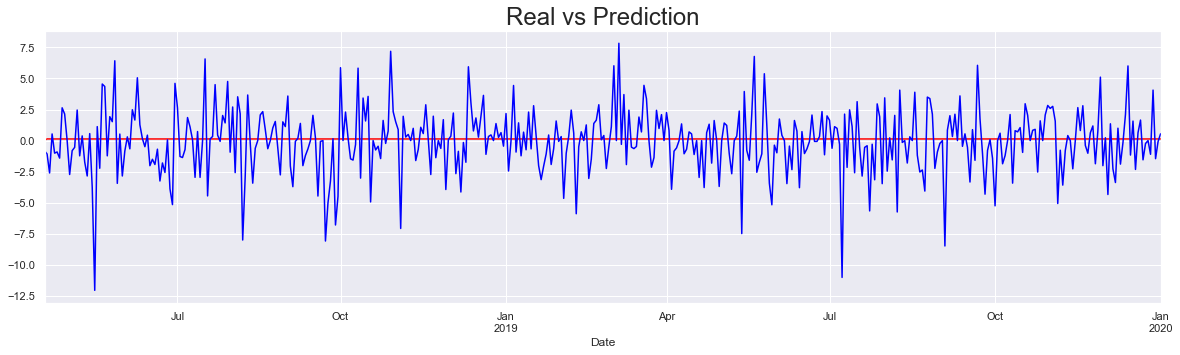

In [57]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_PNB[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_PNB[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

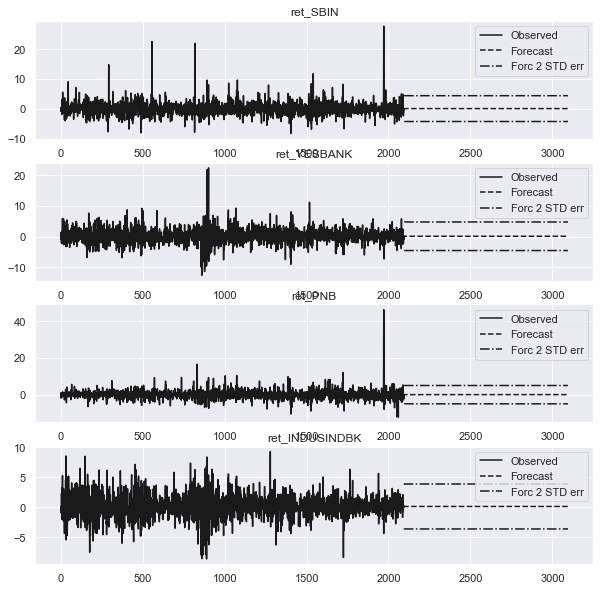

In [58]:
results_var_ret.plot_forecast(1000)
plt.show()